In [ ]:
import os
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib

from CommonTools import (
    convert_CaloToolMPEta_to_IEta,
)


parser = argparse.ArgumentParser()
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true')
parseGroup1.add_argument('--PhiRing',        action='store_true')
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true')
parseGroup2.add_argument('--l1MatchGen',     action='store_true')

runLocally = True

args = None
if not runLocally:
    matplotlib.use('Agg') # use for condor jobs to disable display of plots
    args = parser.parse_args()
else:
    #args = parser.parse_args("--ChunkyDonut --l1MatchGen".split()) # to run in jupyter-notebook     
    #args = parser.parse_args("--PhiRing --l1MatchGen".split()) # to run in jupyter-notebook     
    args = parser.parse_args("--PhiRing --l1MatchOffline".split()) # to run in jupyter-notebook     
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen

printLevel = PrintLevel = 5
iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV
JEC_SF_LowerBound        = 1.00  # mainly for HF SFs
JEC_SF_UpperBound        = 2.00  # mainly for low pT jet SFs

sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 

# Read L1Jet CalibLayer2 SFs from csv files 
NCompPtBins = 16 # 16 # No. of compressed pT bins
calibSF_L1JetPtRange = [15., 255., 1.] # [<lowest pT>,  <hightest pT>,  <pT bin width>] # pT range for SFs to read from Syed's SF.csv file
LUT_PtRange = [0., 255., 1.] # pT range for SFs for LUT
SF_forZeroPt = 1.0


useAdditionalSFForLUT = True # 8/7 factor is needed for PhiRing as different PU estimation considered in CMSSW and Andrew's computation
icalibSF = 0 # 0, 1
calibSFLable = ['SF'][icalibSF]  
sipFileCalibSF = {
    'Default': {
       #'RawPUS': { # Chunky donut
       #    'fileName': '../data/L1T_Jet_SFs_2024v0_20240209_L1JetEt_PUS_ChunkyDonut_v0_HBE_logGenEtByL1Et_atPU33_HF_GenEtByL1Et_atPU33.csv', 
       #    'SFLabel': ['SF'][icalibSF],
       #    'L1JetPtVarName':'L1JetEt_PUS_ChunkyDonut',
       #    'additionalCorrForLUT': 1.0,
       #},
       
       'RawPUS_phiDefault': {
           'fileName': '', # set it below explicitly
           'SFLabel': ['SF'][icalibSF],
           'L1JetPtVarName':'L1JetEt_PUS_PhiRing',
           'additionalCorrForLUT': 1, # 8/7 factor is needed for PhiRing as different PU estimation considered in CMSSW and Andrew's computation.
       },
    },
}



'''
## 2024v0
sIpFileName     = "../data/L1T_Jet_MLInputs_2024_QCD_Pt15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter24Digi-FlatPU0to80_133X_mcRun3_2024_realistic_v8-v3_JEC2024v0_13_3_0_20240209.csv"
sipFileCalibSF['Default']['RawPUS_phiDefault']['fileName'] = '../data/L1T_Jet_SFs_2024v0_20240209_L1JetEt_PUS_PhiRing_HBE_logGenEtByL1Et_atPU33_HF_GenEtByL1Et_atPU33.csv'
version         = "v2024v0_%s_%s_20240209" % (sL1JetEt, sRefJetEt) 
sOutDir         = "./plots_checkL1JetSFs_%s" % (version)
'''
'''
## 2024v0p1
sIpFileName     = "../data/L1T_Jet_MLInputs_2024_QCD_Pt15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter24Digi-FlatPU0to80_133X_mcRun3_2024_realistic_v8-v3_JEC2024v0_13_3_0_ZSHF3p5GeV_20240219.csv"
sipFileCalibSF['Default']['RawPUS_phiDefault']['fileName'] = '../data/L1T_Jet_SFs_2024v0p1_13_3_0_ZSHF3p5GeV_20240219_L1JetEt_PUS_PhiRing_HBE_logGenEtByL1Et_atPU33_HF_GenEtByL1Et_atPU33.csv'
version         = "v2024v0p1_13_3_0_ZSHF3p5GeV_20240219_%s_%s" % (sL1JetEt, sRefJetEt) 
sOutDir         = "./plots_checkL1JetSFs_%s" % (version)
'''
'''
## 2024v0p2_13_3_0_L1SFvOlivier20240219_20240219
sIpFileName     = "../data/L1T_Jet_MLInputs_2024_QCD_Pt15to7000_TuneCP5_13p6TeV_pythia8_Run3Winter24Digi-FlatPU0to80_133X_mcRun3_2024_realistic_v8-v3_JEC2024v0_13_3_0_L1SFvOlivier20240219_20240219.csv"
sipFileCalibSF['Default']['RawPUS_phiDefault']['fileName'] = '../data/L1T_Jet_SFs_2024v0p2_13_3_0_L1SFvOlivier20240219_20240219_L1JetEt_PUS_PhiRing_HBE_logGenEtByL1Et_atPU33_HF_GenEtByL1Et_atPU33.csv'
version         = "v2024v0p2_13_3_0_L1SFvOlivier20240219_20240219_%s_%s" % (sL1JetEt, sRefJetEt) 
sOutDir         = "./plots_checkL1JetSFs_%s" % (version)
'''
'''
## 2024Ev0_DCSOnlyJSON_14_0_7
sIpFileName     = "../data/L1T_Jet_MLInputs_2024Ev0_DCSOnlyJSON_14_0_7_20240606.csv"
sipFileCalibSF['Default']['RawPUS_phiDefault']['fileName'] = '../data/L1T_Jet_SFs_JEC2024Ev0_DCSOnlyJSON_14_0_7_L1JetEt_PUS_PhiRing_HBE_logGenEtByL1Et_atPU33_HF_GenEtByL1Et_atPU33.csv'
version         = "vJEC2024Ev0_DCSOnlyJSON_14_0_7_%s_%s" % (sL1JetEt, sRefJetEt) 
sOutDir         = "./plots_checkL1JetSFs_%s" % (version)
sRefJetEt = sOfflineJetEt
'''

## 2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV
sIpFileName     = "../output.csv"
sipFileCalibSF['Default']['RawPUS_phiDefault']['fileName'] = '../data/L1T_Jet_SFs_JEC2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV_L1JetEt_PUS_PhiRing_HBE_logGenEtByL1Et_atPU33_HF_GenEtByL1Et_atPU33.csv'
version         = "vJEC2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV_%s_%s" % (sL1JetEt, sRefJetEt) 
sOutDir         = "./plots_checkL1JetSFs_%s" % (version)
sRefJetEt = sOfflineJetEt


PU_Cat = OD()
PU_Cat['PUlt38']   = [ 0, 38]
PU_Cat['PU39to57'] = [39, 57]
PU_Cat['PUgt58']   = [58, 99]

PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

ETA_CAT = OD()
ETA_CAT['HBEF'] = [0.000, 5.210]  ## Whole detector, 1 - 41
ETA_CAT['HB']   = [0.000, 1.392]  ## Trigger towers  1 - 16
ETA_CAT['HE1']  = [1.392, 1.740]  ## Trigger towers 17 - 20
ETA_CAT['HE2a'] = [1.740, 2.322]  ## Trigger towers 21 - 25
ETA_CAT['HE2b'] = [2.322, 3.000]  ## Trigger towers 26 - 28
ETA_CAT['HF']   = [3.000, 5.210]  ## Trigger towers 30 - 41

IETA_CAT = OD()
IETA_CAT['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT['HE1']  = [17, 20]  ## Trigger towers 17 - 20
IETA_CAT['HE2a'] = [21, 25]  ## Trigger towers 21 - 25
IETA_CAT['HE2b'] = [26, 28]  ## Trigger towers 26 - 28
IETA_CAT['HF']   = [30, 41]  ## Trigger towers 30 - 41

IETA_CAT2 = OD()
IETA_CAT2['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT2['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT2['HE1']  = [17, 28]  ## Trigger towers 17 - 28
IETA_CAT2['HF']   = [30, 41]  ## Trigger towers 30 - 41


CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018 = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 9+1)]),  # 1
    ( 2, [*range(10,13+1)]), # 2
    ( 3, [*range(14,15+1)]), # 3
    ( 4, [*range(16,17+1)]), # 4
    ( 5, [*range(18,19+1)]), # 5
    ( 6, [*range(20,21+1)]), # 6
    ( 7, [22]), # 7
    ( 8, [23]), # 8
    ( 9, [24]), # 9
    (10, [25]), # 10
    (11, [26]), # 11
    (12, [*range(27,28+1)]), # 12
    (13, [*range(29,31+1)]), # 13
    (14, [*range(32,35+1)]), # 14
    (15, [*range(36,40+1)]), # 15
])
CaloToolMPEtaBinsMerge_forEtaCompressedLUT = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 10+1)]),  # 1
    ( 2, [*range(11,15+1)]), # 2
    ( 3, [*range(16,20+1)]), # 3
    ( 4, [*range(21,23+1)]), # 4
    ( 5, [*range(24,25+1)]), # 5
    ( 6, [26]), # 6
    ( 7, [27]), # 7
    ( 8, [28]), # 8
    ( 9, [*range(29,31+1)]), # 9
    (10, [*range(32,35+1)]), # 10
    (11, [*range(36,40+1)]), # 11
])

pTBinEdges_forResolutionPlot = np.array([
    # 62 bins, 63 bin edges,
    # [  0  15  20  25  30  35  40  45  50  55  60  70  80  90 100 110 130 150  170 190 220 250 300]
    *range(  0,  14+1, 15),
    *range( 15,  59+1,  5),
    *range( 60, 109+1,10),
    *range(110, 189+1,20),
    *range(190, 255+1,30),    
    300
])
pTBinCenters_forResolutionPlot = (pTBinEdges_forResolutionPlot[:-1] + pTBinEdges_forResolutionPlot[1:]) / 2

useAbsEtaBins = True
ETA_Bins = []
for iEta in range(-41,42):
    if iEta in [-29, 0, 29]:        continue;
    if useAbsEtaBins and iEta < 0:  continue;
    ETA_Bins.append(str(iEta))

map_CaloIEta_to_CaloTool_mpEta = OrderedDict([
    (1, 1),
    (2, 2),
    (3, 3),
    (4, 4),
    (5, 5),
    (6, 6),
    (7, 7),
    (8, 8),
    (9, 9),
    (10, 10),
    
    (11, 11),
    (12, 12),
    (13, 13),
    (14, 14),
    (15, 15),
    (16, 16),
    (17, 17),
    (18, 18),
    (19, 19),
    (20, 20),
    
    (21, 21),
    (22, 22),
    (23, 23),
    (24, 24),
    (25, 25),
    (26, 26),
    (27, 27),
    (28, 28),
    (29, 29),
    (30, 29),
    
    (31, 30),
    (32, 31),
    (33, 32),
    (34, 33),
    (35, 34),
    (36, 35),
    (37, 36),
    (38, 37),
    (39, 38),
    (40, 39),

    (41, 40),
])

data_all = pd.read_csv(sIpFileName)
print("Input file: %s" % (sIpFileName))
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))
print("l1Jet_ChunkyDonut {}, l1Jet_PhiRing {}, l1MatchOffline {}, l1MatchGen {}".format(
    l1Jet_ChunkyDonut, l1Jet_PhiRing, l1MatchOffline, l1MatchGen))

Input file: ../output.csv
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sRefJetEt: PFJetEtCorr, 	 sL1Jet: L1JetEt_PUS_PhiRing, 	 L1JetPtThrsh: 10.0
l1Jet_ChunkyDonut False, l1Jet_PhiRing True, l1MatchOffline True, l1MatchGen False


In [2]:
jetShape = 'Default'
PUSAlgo = 'RawPUS' if l1Jet_ChunkyDonut else 'RawPUS_phiDefault'
sipFileCalibSF_toRead = sipFileCalibSF[jetShape][PUSAlgo]['fileName']
print(f'sipFileCalibSF_toRead: {sipFileCalibSF_toRead}')


data_calibSFs =  OrderedDict()
for Eta_bin in ETA_Bins:
    data_calibSFs[int(Eta_bin)] = OrderedDict()
    for Pt in np.arange(LUT_PtRange[0], LUT_PtRange[1]+1, LUT_PtRange[2]):
        data_calibSFs[int(Eta_bin)][Pt] = 0.0

with open(sipFileCalibSF_toRead, mode='r') as fipFileCalibSF_toRead:
    calibSF_csv_reader = csv.DictReader(fipFileCalibSF_toRead)
    for calibSF_csv_row in calibSF_csv_reader:
        iEta_tmp = int(calibSF_csv_row['L1JetTowerIEtaAbs']) # str
        l1JetPt_tmp = float(calibSF_csv_row[ sipFileCalibSF[jetShape][PUSAlgo]['L1JetPtVarName'] ])
        SF_tmp = float(calibSF_csv_row[ sipFileCalibSF[jetShape][PUSAlgo]['SFLabel'] ]) * sipFileCalibSF[jetShape][PUSAlgo]['additionalCorrForLUT']             

        data_calibSFs[iEta_tmp][l1JetPt_tmp] = SF_tmp

        
# Updates SFs for lowpT and hightPt bins --------------------------------------------------------------
for Eta_bin in list(data_calibSFs.keys()):
    if len(list(data_calibSFs[Eta_bin].keys())) == 0: # Not all Eta_Bins were used to extract SFs
        continue

    #print("data_calibSFs[{}]: {},  {}".format(Eta_bin, data_calibSFs[Eta_bin].keys(), calibSF_L1JetPtRange[0]))
    #if float(calibSF_L1JetPtRange[0]) not in data_calibSFs[Eta_bin].keys():
    if calibSF_L1JetPtRange[0] not in data_calibSFs[Eta_bin].keys():
        print("L1 pT {} not in data_calibSFs[ieta={}] \t\t **** ERROR ****".format(calibSF_L1JetPtRange[0], Eta_bin))
    sTmp = "Eta %d: \nLowPt: " % (Eta_bin)

    for Pt in np.arange(LUT_PtRange[0], calibSF_L1JetPtRange[0]):
        if abs(Pt - 0) < 0.0001:
            data_calibSFs[Eta_bin][Pt] = SF_forZeroPt
            # Add Pt=0 at the beining in OrderedDict
            #data_calibSFs[Eta_bin].update( {Pt : SF_forZeroPt } )
            #data_calibSFs[Eta_bin].move_to_end(Pt, last=False)
        else:
            data_calibSFs[Eta_bin][Pt] = data_calibSFs[Eta_bin][calibSF_L1JetPtRange[0]]
        sTmp += " ({}, {}),".format(Pt, data_calibSFs[Eta_bin][Pt])
    sTmp += "\nHighPt: "
    for Pt in np.arange(calibSF_L1JetPtRange[1]+1., LUT_PtRange[1]+1.):
        data_calibSFs[Eta_bin][Pt] = data_calibSFs[Eta_bin][calibSF_L1JetPtRange[1]]
        sTmp += " ({}, {}),".format(Pt, data_calibSFs[Eta_bin][Pt])
    if PrintLevel >= 12:
        print(sTmp)
    if PrintLevel >= 12:
        print("data_calibSFs[{}] after: {}".format(Eta_bin, data_calibSFs[Eta_bin]))
# ------------------------------------------------------------------------------------------------------        
        
        

sipFileCalibSF_toRead: ../data_m013/L1T_Jet_SFs_JEC2024Ev0_DCSOnlyJSON_14_0_7_ZSHF3p5GeV_L1JetEt_PUS_PhiRing_HBE_logGenEtByL1Et_atPU33_HF_GenEtByL1Et_atPU33.csv


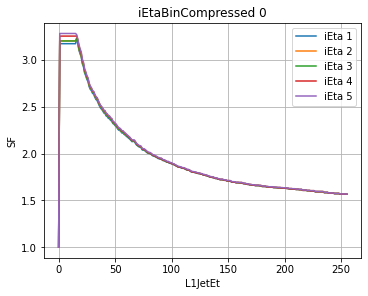

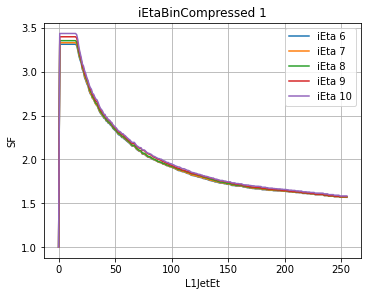

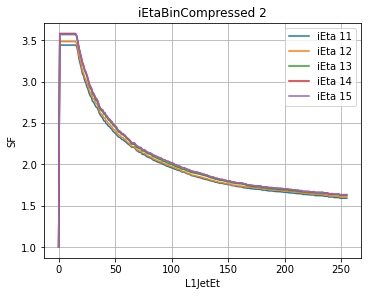

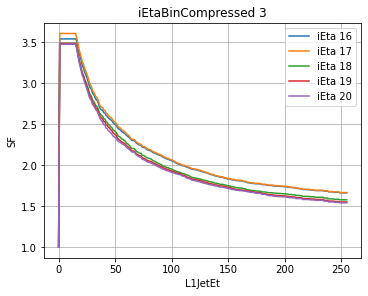

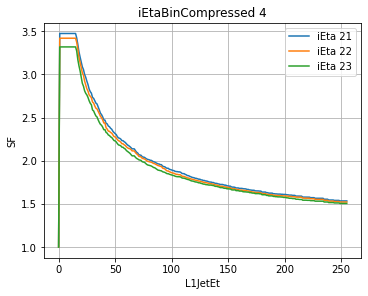

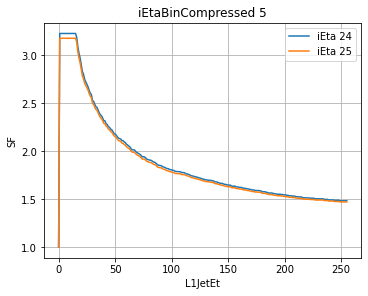

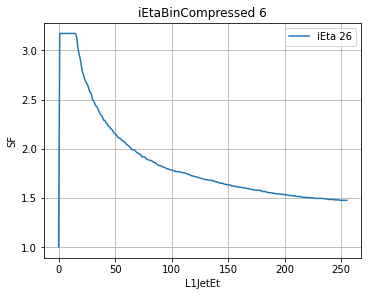

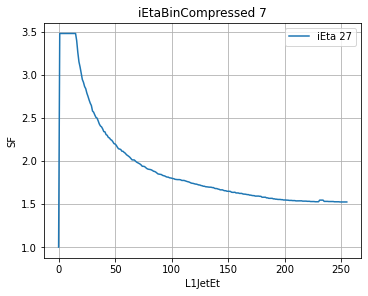

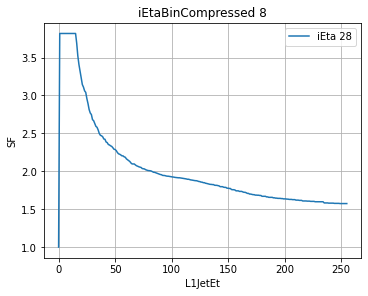

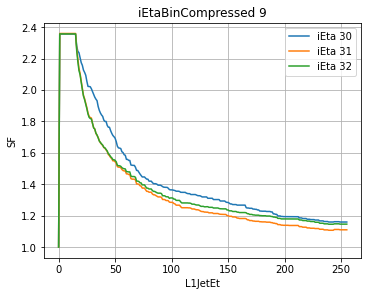

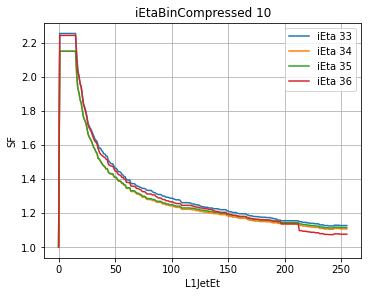

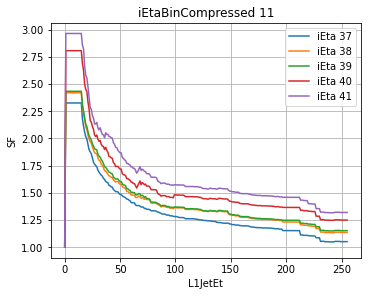

In [3]:
# plot SFs -----------------------------------
sOutDir_toUse = '%s/SFs' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        #if iEtaBin not in data_calibSFs.keys(): continue
        axs.plot(list(data_calibSFs[iEtaBin].keys()), list(data_calibSFs[iEtaBin].values()), label='iEta %d'%(iEtaBin))
        
    axs.set_xlabel('L1JetEt')                 
    axs.set_ylabel('SF')
    axs.set_title('iEtaBinCompressed %d' % (iEtaBinCompressed))
    axs.grid()
    axs.legend()
        
    fig.savefig('%s/L1JEC_PtUncompressed_iEta%d.pdf' % (sOutDir_toUse, iEtaBinCompressed))


In [ ]:
if l1Jet_ChunkyDonut:
    data_all[sL1JetEt] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']
else:
    data_all[sL1JetEt] = data_all['L1JetDefault_RawEt'] - data_all['L1JetDefault_PUEt_PhiRing']
    # data_all[sL1JetEt] = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )

In [5]:
sL1JetEt_calib = '%s_calib' % (sL1JetEt)
data_copy1     = data_all[[sL1JetTowerIEtaAbs, sL1JetEt, sRefJetEt]].copy()

def calibrateJet(Et_0, iEta):
    Et = round(Et_0)
    if Et < calibSF_L1JetPtRange[0]: Et = round(calibSF_L1JetPtRange[0])
    if Et > calibSF_L1JetPtRange[1]: Et = round(calibSF_L1JetPtRange[1])
    #print(f"iEta {iEta}, Et {Et}")
    #sf = SFs_dict[(iEta, Et)] if Et >= 1 else SF_forZeroPt
    sf = data_calibSFs[iEta][Et] if Et >= 1 else SF_forZeroPt
    return Et_0 * sf

#def calibrateJet(Et_0, iEta):
#    Et = round(Et_0)
#    if Et > LUT_PtRange[1]: Et = LUT_PtRange[1]
#    #print(f"iEta {iEta}, Et {Et}")
#    #print(f"data_calibSFs[{iEtaBin}][{Et}] {data_calibSFs[iEtaBin][Et]}")
#    return Et_0 * data_calibSFs[iEta][Et]

data_copy1[sL1JetEt_calib] = data_copy1.apply(lambda row: calibrateJet(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)
#data_copy1[sL1JetEt_calib] = np.vectorize(calibrateJet)(data_copy1[sL1JetEt], data_copy1[sL1JetTowerIEtaAbs])
if printLevel >= 10:
    print("data_copy1: {}".format(data_copy1))

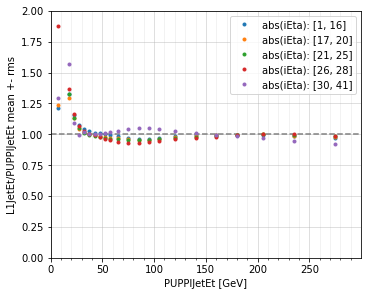

In [6]:
# L1T respones vs Pt: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJEC/L1JetResponse_vs_Pt' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]
    
    L1JetPtResponse_vs_pt_dict = []
    L1JetPtResponseRMS_vs_pt_dict = []
    for iPtBin in range(0, len(pTBinEdges_forResolutionPlot)-1):
        pT_low  = pTBinEdges_forResolutionPlot[iPtBin]
        pT_high = pTBinEdges_forResolutionPlot[iPtBin+1]
        #print(f"{iPtBin = }, {pT_low = }, {pT_high = }")

        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_copy1[sRefJetEt]  >= pT_low) & 
            (data_copy1[sRefJetEt]  <  pT_high)
            ) ]
        res_ = data_copy1_iEtaBin[sL1JetEt_calib] / data_copy1_iEtaBin[sRefJetEt]
        L1JetPtResponse_vs_pt_dict.append( np.mean(res_) )
        L1JetPtResponseRMS_vs_pt_dict.append( np.std(res_) )
    
    axs.errorbar(
        pTBinCenters_forResolutionPlot,
        L1JetPtResponse_vs_pt_dict,
        #yerr = L1JetPtResponseRMS_vs_pt_dict,
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        marker = '.',
        ls='none'
    )
    

axs.set_xlabel('PUPPIJetEt [GeV]')
axs.set_ylabel('L1JetEt/PUPPIJetEt mean +- rms')
# axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1])
axs.set_ylim(0, 2)
axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.grid()
axs.legend()

axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 50))
axs.set_xticks(np.arange(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], 10), minor=True)

axs.grid(which='minor', alpha=0.2)
axs.grid(which='major', alpha=0.5)
        
fig.savefig('%s/L1JetResponse_vs_Pt_%s.pdf' % (sOutDir_toUse, sL1JetEt))


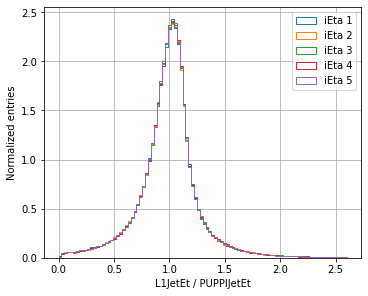

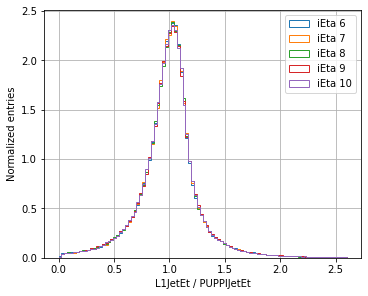

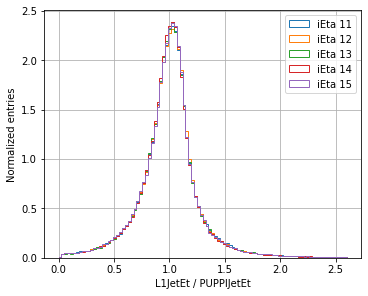

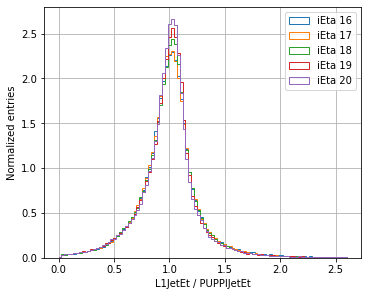

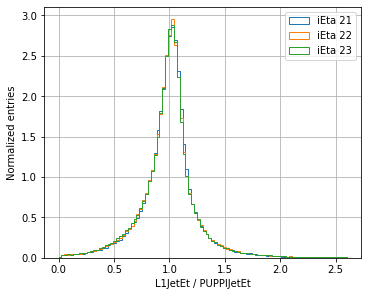

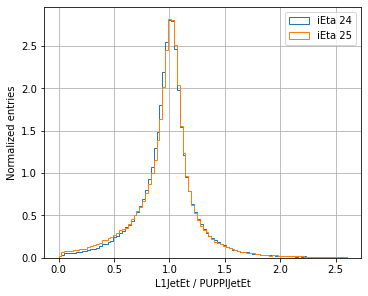

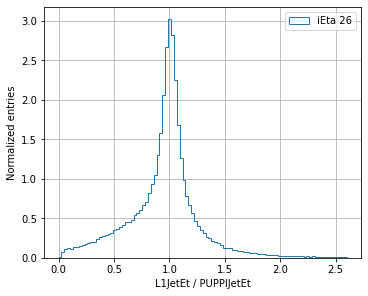

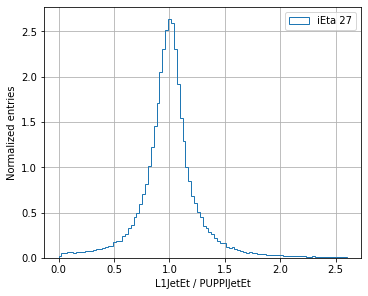

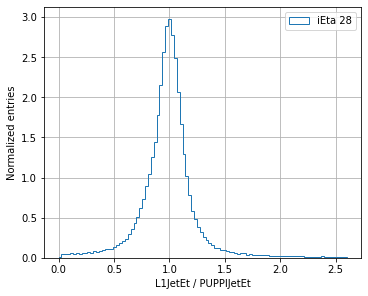

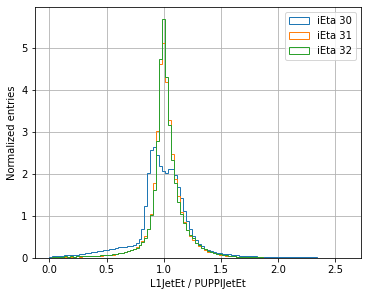

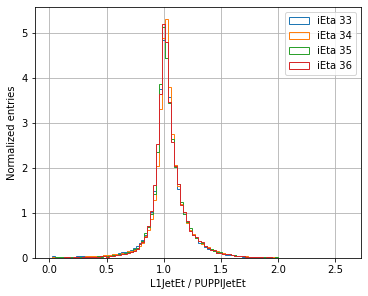

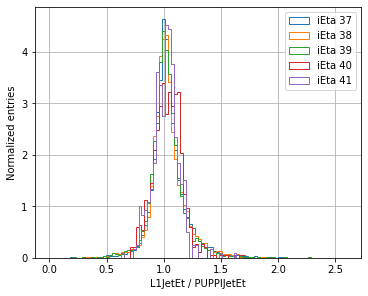

In [7]:
# Resolution plots 
sOutDir_toUse = '%s/AfterJEC/L1JetResponse_periEta' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_copy1_iEtaBin = data_copy1[data_copy1[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    # axs.set_title('%s' % (sL1JetEt))
    axs.grid()
    axs.legend()
        
    fig.savefig('%s/L1JetResponse_%s_ieta_%d_to_%d.pdf' % (sOutDir_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))

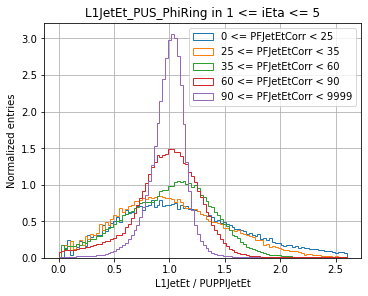

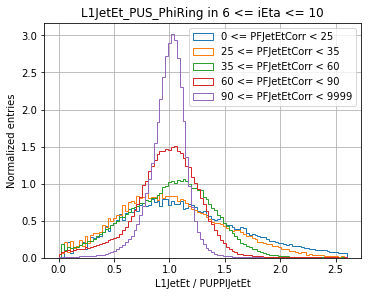

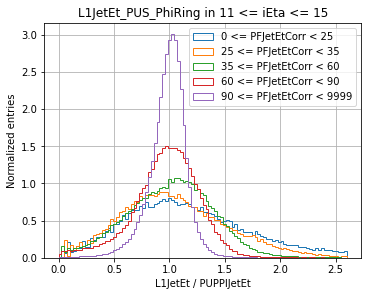

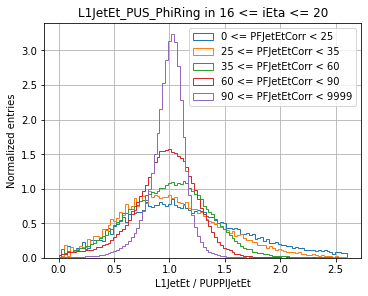

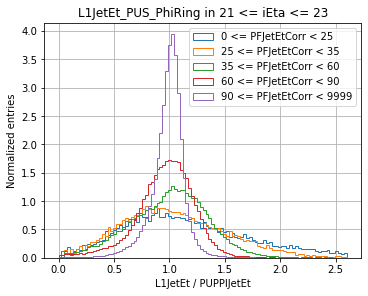

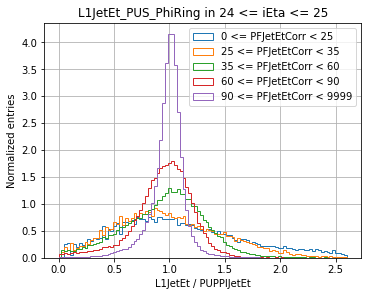

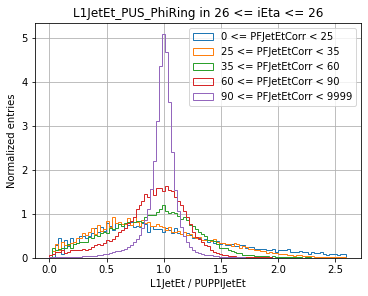

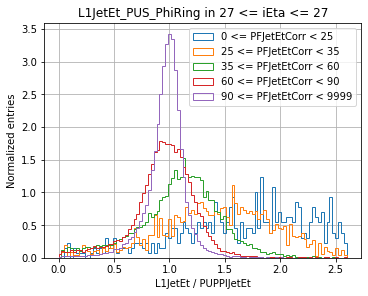

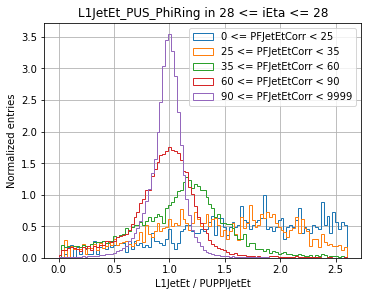

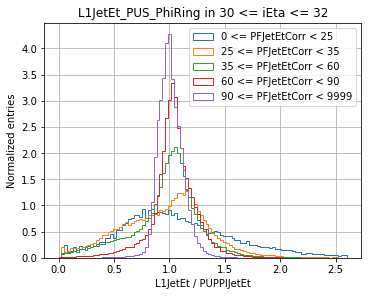

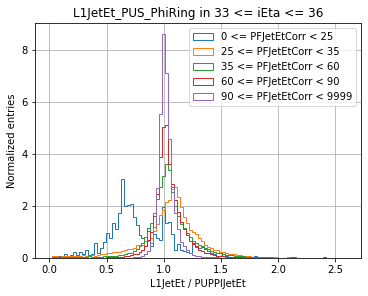

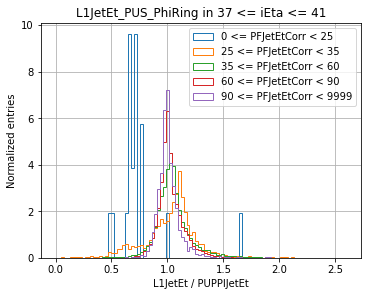

In [8]:
# Resolution plots 
sOutDir_toUse = '%s/AfterJEC/L1JetResponse_perEtaCat_PtCat' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sRefJetEt] >= pt_range[0]) & 
            (data_copy1[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= PUPPIJetEt < %d' % (pt_range[0], pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.grid()
    axs.legend()
        
    fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))

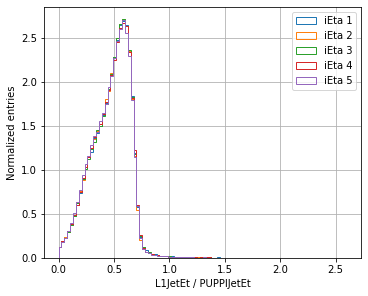

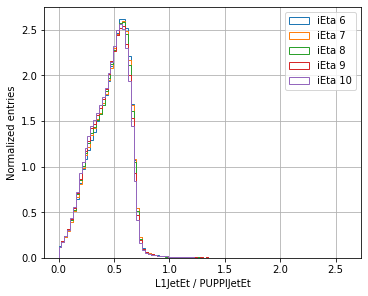

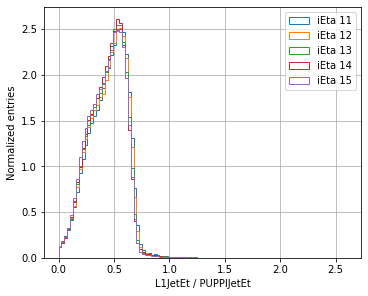

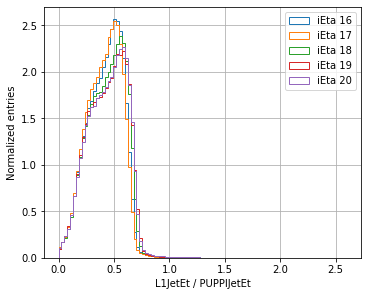

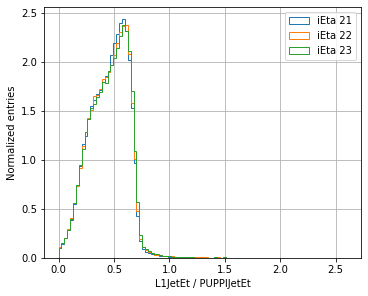

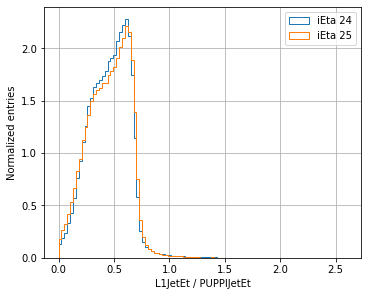

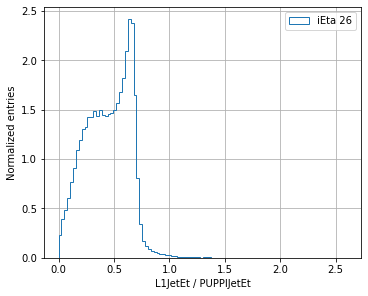

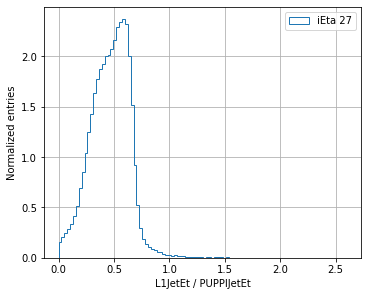

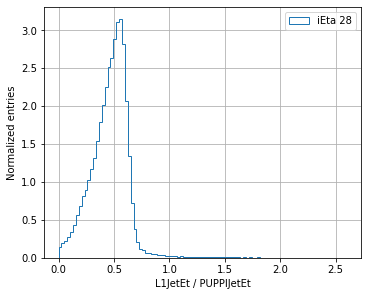

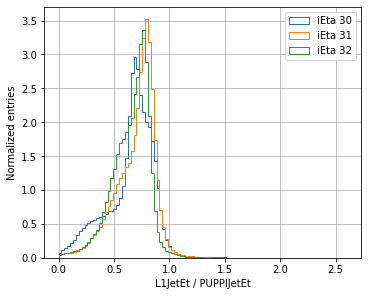

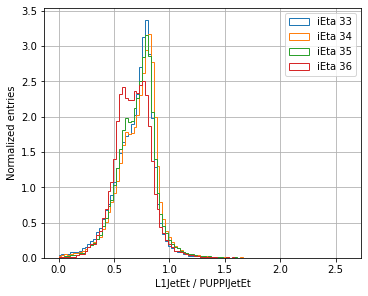

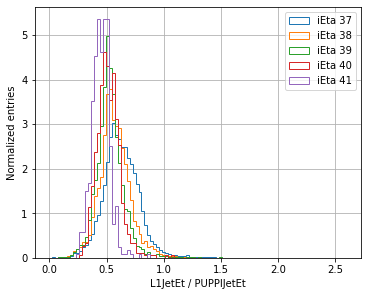

In [9]:
# Resolution plots: before JEC
sOutDir_toUse = '%s/BeforeJEC/L1JetResponse_perEtaCat' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_copy1_iEtaBin = data_copy1[data_copy1[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    # axs.set_title('%s' % (sL1JetEt))
    axs.grid()
    axs.legend()
        
    fig.savefig('%s/BeforeJEC_%s_ieta_%d_to_%d.pdf' % (sOutDir_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))

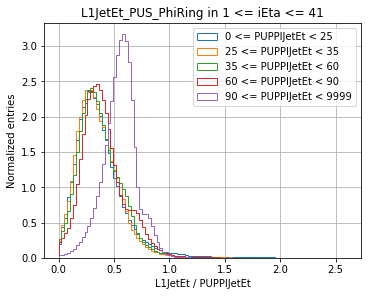

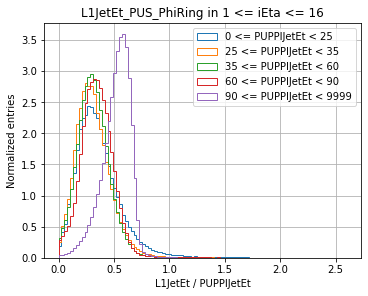

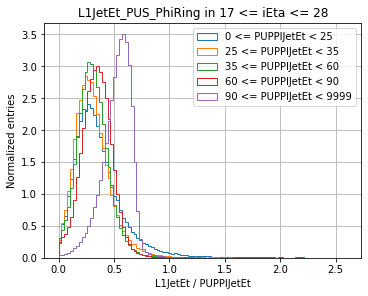

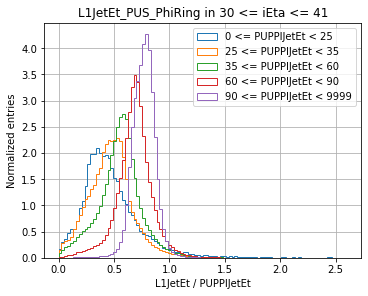

In [ ]:
# Resolution plots: before JEC
sOutDir_toUse = '%s/BeforeJEC/L1JetResponse_perEtaCat_perPtCat' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

# for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():          #original
#     #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
#     fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
#     iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
#     iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])

for iEtaCatname, iEtaCatRange in IETA_CAT2.items():                     #modified to match ../makeLUTs/check_L1TJECLUT_performance.ipynb
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = iEtaCatRange[0]
    iEtaBin_last  = iEtaCatRange[1]
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy1_iEtaBin = data_copy1[ (
            (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy1[sRefJetEt] >= pt_range[0]) & 
            (data_copy1[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy1_iEtaBin[sL1JetEt]/data_copy1_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= PUPPIJetEt < %d' % (pt_range[0], pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
    axs.grid()
    axs.legend()
        
    fig.savefig('%s/BeforeJEC_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))

/eos/user/d/ddharmen/.local/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/eos/user/d/ddharmen/.local/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/eos/user/d/ddharmen/.local/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/eos/user/d/ddharmen/.local/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/eos/user/d/ddharmen/.local/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/eos/user/d/ddharmen/.local/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  retur

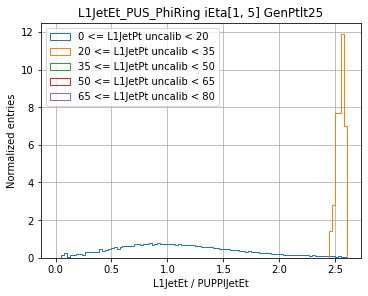

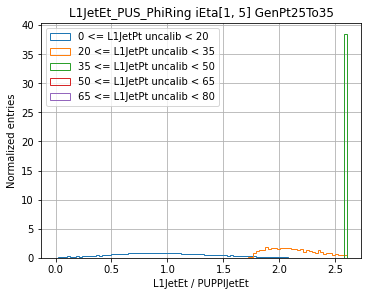

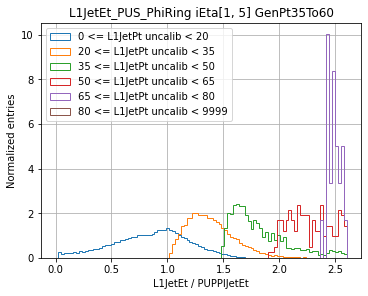

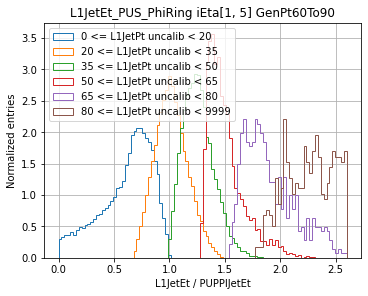

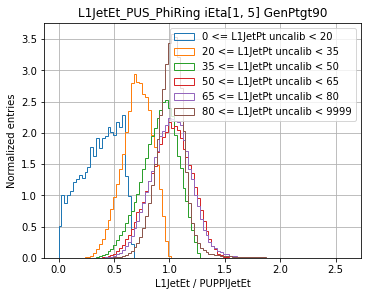

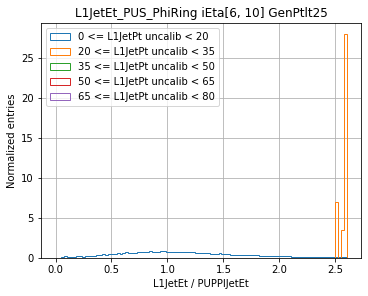

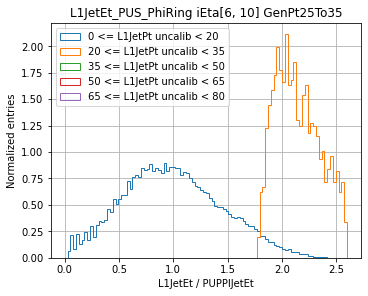

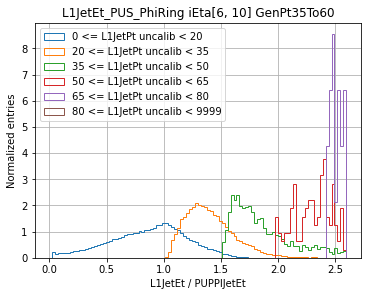

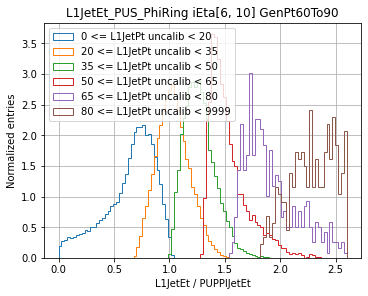

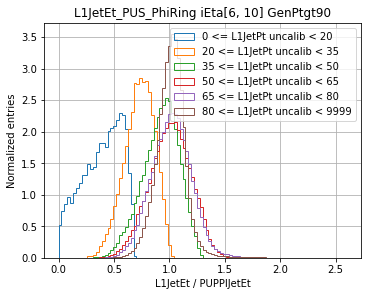

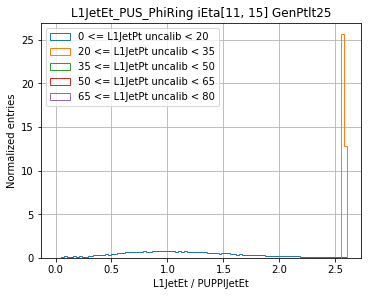

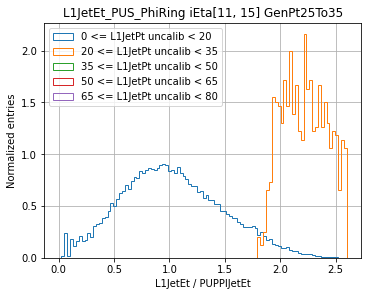

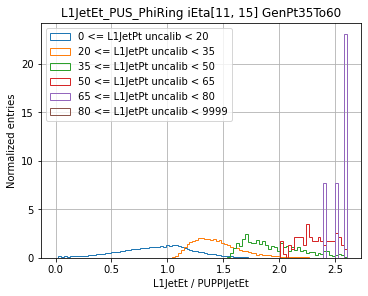

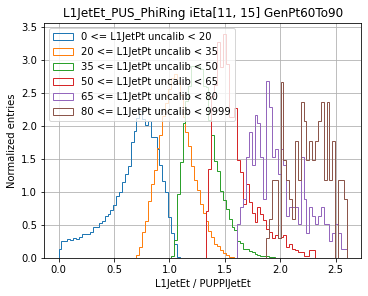

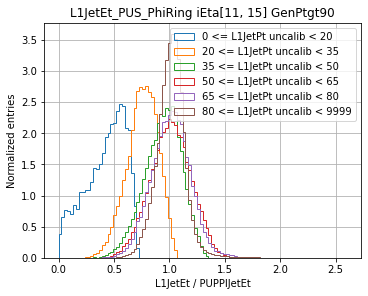

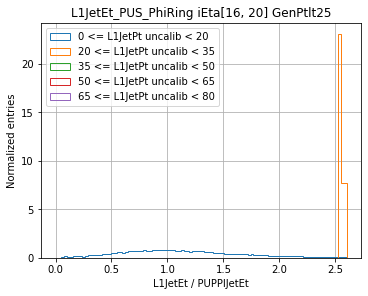

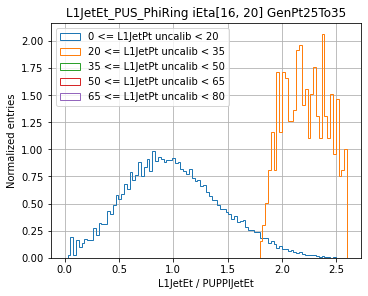

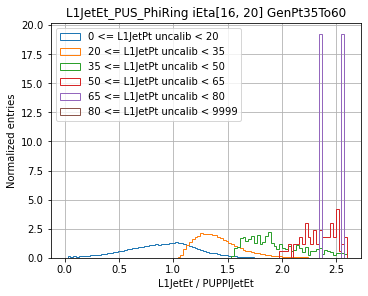

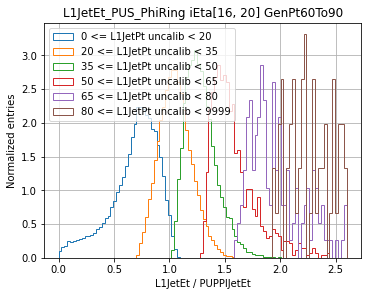

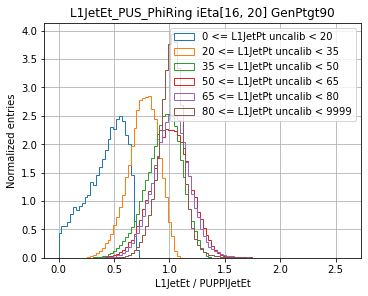

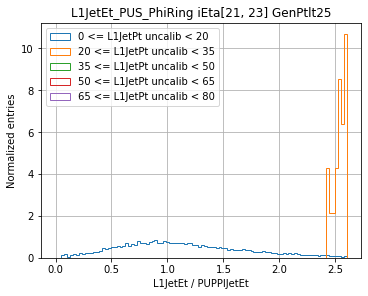

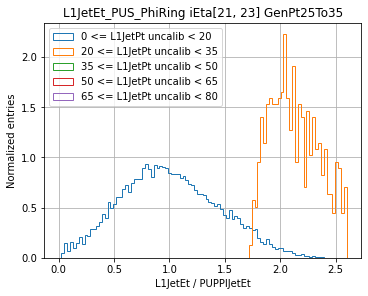

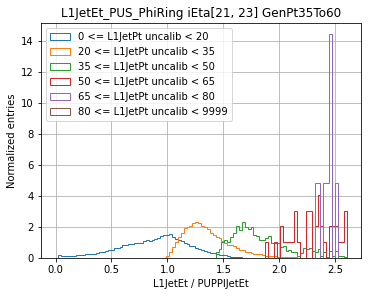

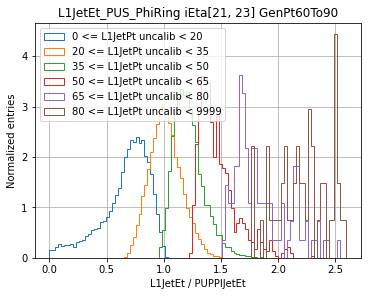

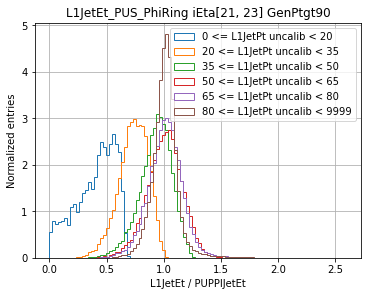

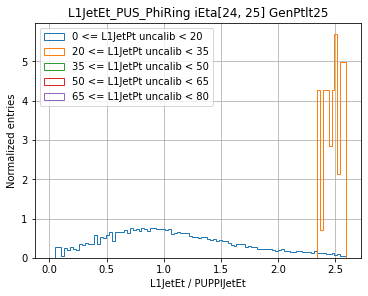

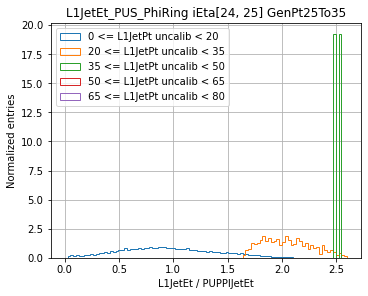

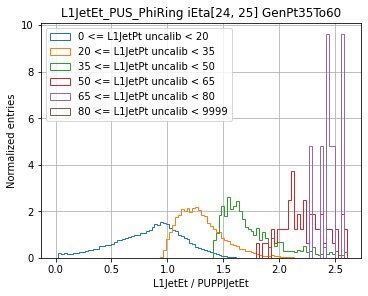

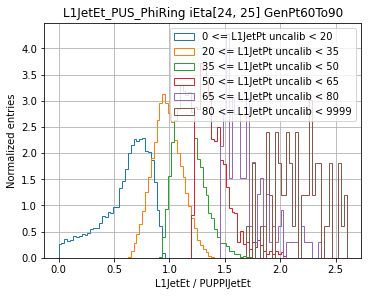

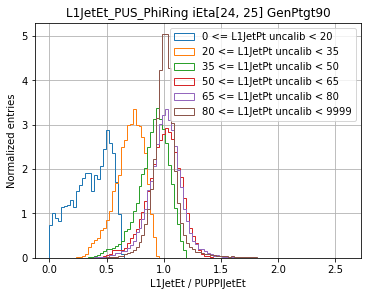

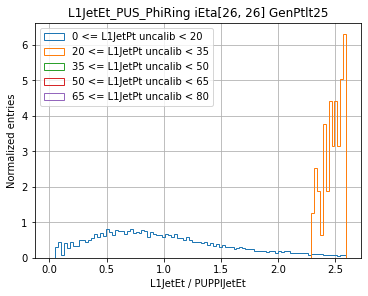

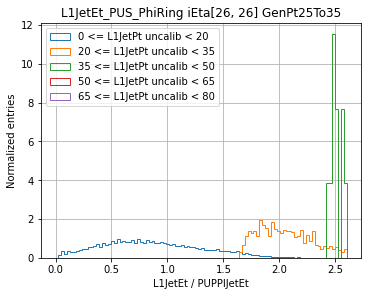

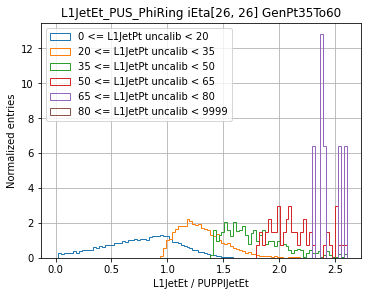

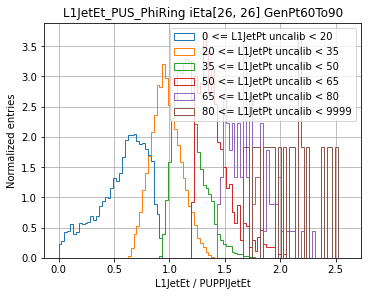

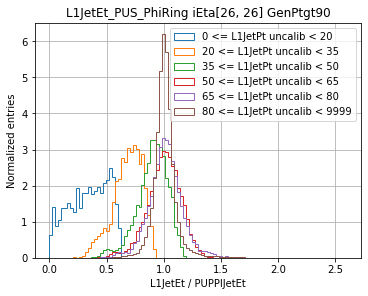

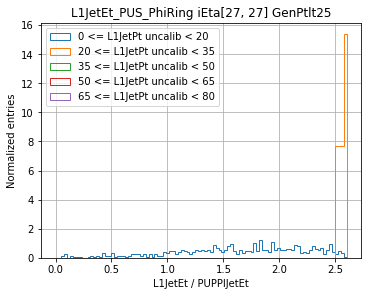

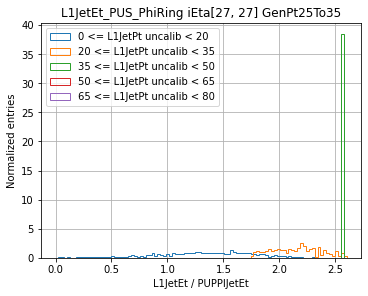

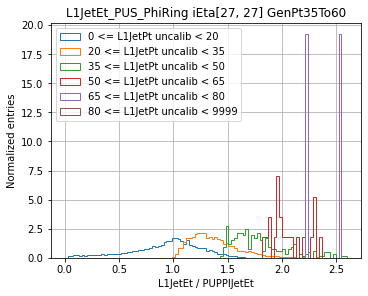

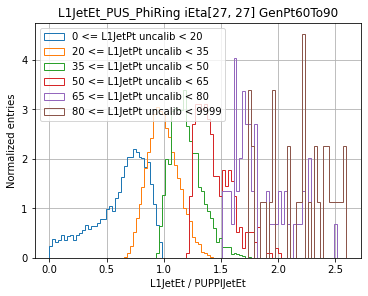

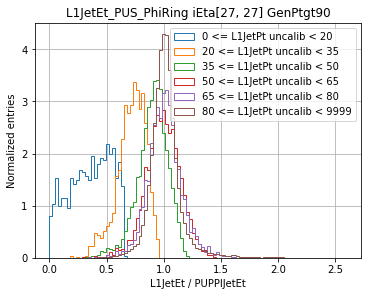

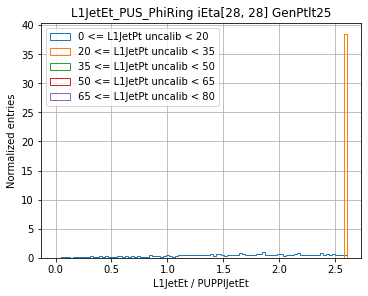

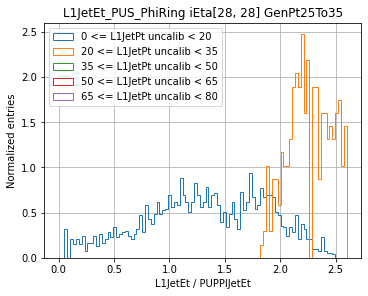

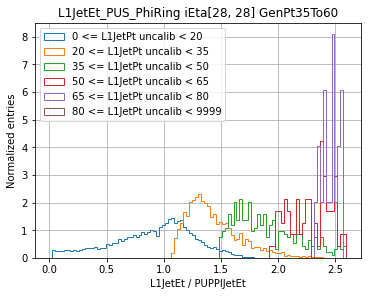

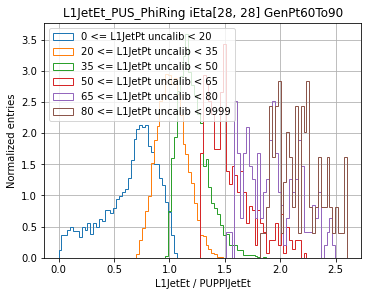

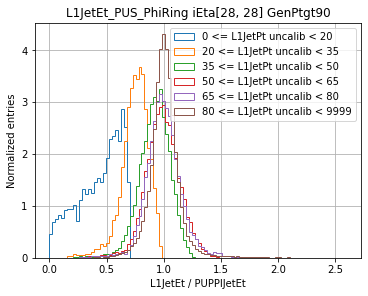

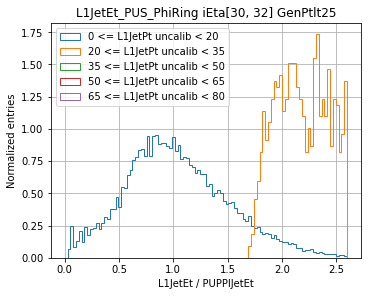

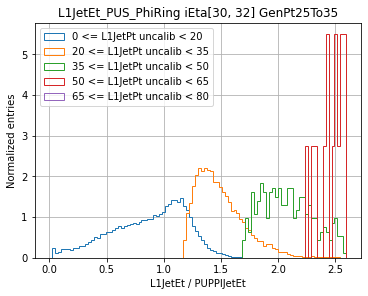

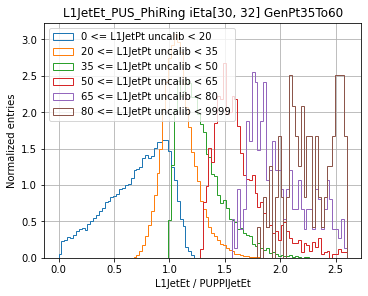

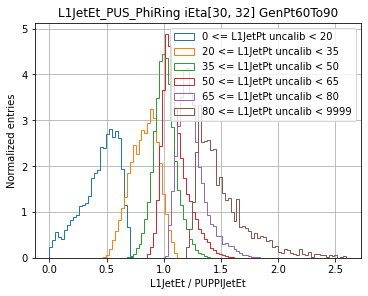

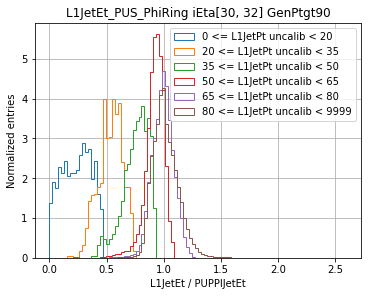

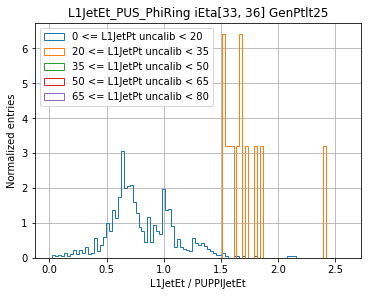

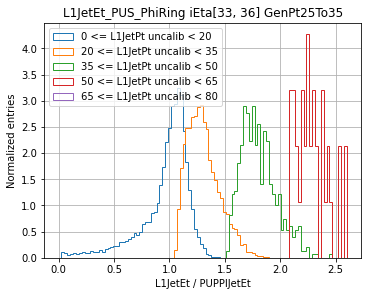

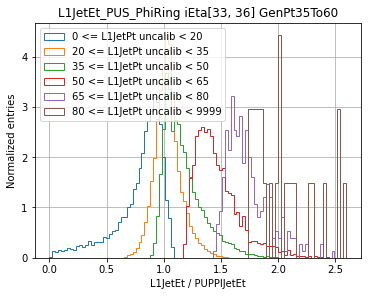

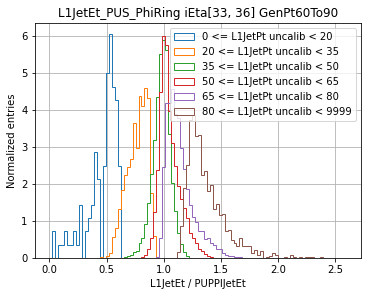

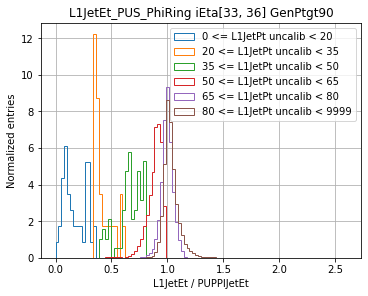

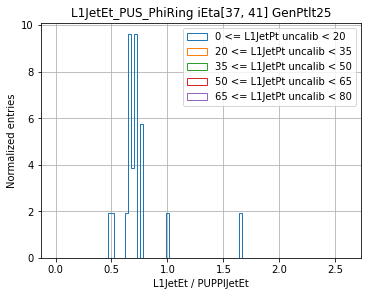

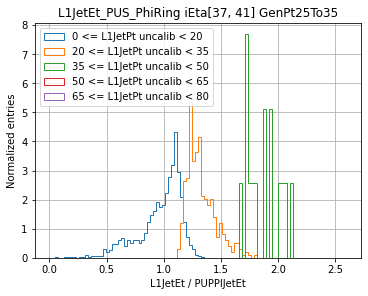

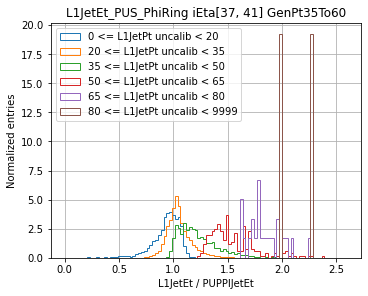

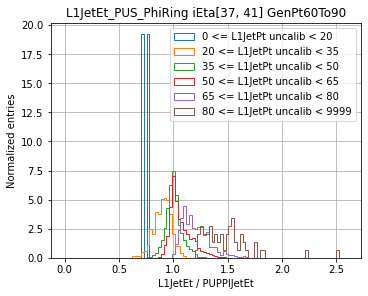

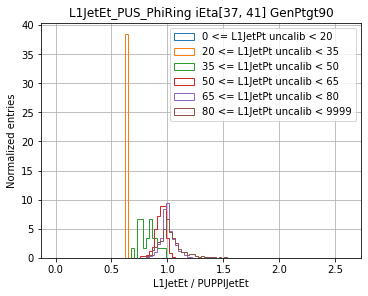

In [11]:
# Resolution plots 
sOutDir_toUse = '%s/AfterJEC/L1JetResponse_perEtaCat_perPtCat_2' % (sOutDir)
os.makedirs(sOutDir_toUse, exist_ok=True )

PT_CAT_2 = OD()
PT_CAT_2['Ptlt20']   = [ 0,  15,   20]  ## Low pT, turn-on threshold, high pT
PT_CAT_2['Pt20To35'] = [20,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT_2['Pt35To50'] = [35,  55,   50]  ## Low pT, turn-on threshold, high pT
PT_CAT_2['Pt50To65'] = [50,  75,   65]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT_2['Pt65To80'] = [65,  75,   80]  ## Low pT, turn-on threshold, high pT   
PT_CAT_2['Ptgt80']   = [80, 120, 9999]  ## Low pT, turn-on threshold, high pT

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():     
    iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
    iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
    
    for pt_cat, pt_range in PT_CAT.items(): 
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained') 
        for pt_cat_2, pt_range_2 in PT_CAT_2.items(): 
            if pt_cat in ['Ptlt25', 'Pt25To35'] and  pt_cat_2=='Ptgt80': continue
            data_copy1_iEtaBin = data_copy1[ (
                (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
                (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
                (data_copy1[sRefJetEt] >= pt_range[0]) & 
                (data_copy1[sRefJetEt] <  pt_range[2]) &
                (data_copy1[sL1JetEt]  >= pt_range_2[0]) &
                (data_copy1[sL1JetEt]  <  pt_range_2[2]) )]
            axs.hist(
                (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='%d <= %s < %d' % (pt_range_2[0], 'L1JetPt uncalib', pt_range_2[2]),
                histtype='step',#, linewidth=2
                density=True
            )
        axs.set_xlabel('L1JetEt / PUPPIJetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('%s iEta[%d, %d] Gen%s' % (sL1JetEt, iEtaBin_first, iEtaBin_last, pt_cat))
        axs.grid()
        axs.legend()
        
        fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d_inPtCat_GenJet%s.pdf' % (sOutDir_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1]), pt_cat))

In [12]:
def calibrateJet_wManipulate(Et_0, iEta):
    Et = round(Et_0)
    if Et < calibSF_L1JetPtRange[0]: Et = round(calibSF_L1JetPtRange[0])
    if Et > calibSF_L1JetPtRange[1]: Et = round(calibSF_L1JetPtRange[1])
    #print(f"iEta {iEta}, Et {Et}")
    #sf = SFs_dict[(iEta, Et)] if Et >= 1 else SF_forZeroPt
    sf = data_calibSFs[iEta][Et] if Et >= 1 else SF_forZeroPt
    if sf < JEC_SF_LowerBound: sf = JEC_SF_LowerBound
    return Et_0 * sf


In [13]:
data_copy2_calibJetwManipulate     = data_all[[sL1JetTowerIEtaAbs, sL1JetEt, sRefJetEt]].copy()
data_copy2_calibJetwManipulate[sL1JetEt_calib] = data_copy2_calibJetwManipulate.apply(lambda row: calibrateJet_wManipulate(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)

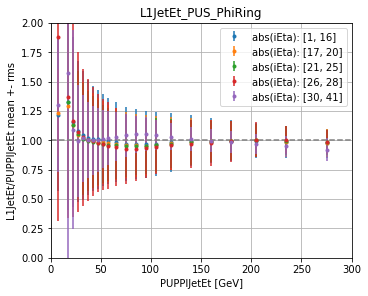

In [14]:
# L1T respones vs Pt: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJECwSFgt%.2f/L1JetResponse_vs_Pt' % (sOutDir, JEC_SF_LowerBound)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]
    
    L1JetPtResponse_vs_pt_dict = []
    L1JetPtResponseRMS_vs_pt_dict = []
    for iPtBin in range(0, len(pTBinEdges_forResolutionPlot)-1):
        pT_low  = pTBinEdges_forResolutionPlot[iPtBin]
        pT_high = pTBinEdges_forResolutionPlot[iPtBin+1]
        #print(f"{iPtBin = }, {pT_low = }, {pT_high = }")

        data_copy2_calibJetwManipulate_iEtaBin = data_copy2_calibJetwManipulate[ (
            (data_copy2_calibJetwManipulate[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy2_calibJetwManipulate[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_copy2_calibJetwManipulate[sRefJetEt]  >= pT_low) & 
            (data_copy2_calibJetwManipulate[sRefJetEt]  <  pT_high)
            ) ]
        res_ = data_copy2_calibJetwManipulate_iEtaBin[sL1JetEt_calib] / data_copy2_calibJetwManipulate_iEtaBin[sRefJetEt]
        L1JetPtResponse_vs_pt_dict.append( np.mean(res_) )
        L1JetPtResponseRMS_vs_pt_dict.append( np.std(res_) )
    
    axs.errorbar(
        pTBinCenters_forResolutionPlot,
        L1JetPtResponse_vs_pt_dict,
        yerr = L1JetPtResponseRMS_vs_pt_dict,
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        marker = '.',
        ls='none'
    )
    

axs.set_xlabel('PUPPIJetEt [GeV]' )
axs.set_ylabel('L1JetEt/PUPPIJetEt mean +- rms')
axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1])
axs.set_ylim(0, 2)
axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.grid()
axs.legend()
    
fig.savefig('%s/L1JetResponse_vs_Pt_%s.pdf' % (sOutDir_toUse, sL1JetEt))


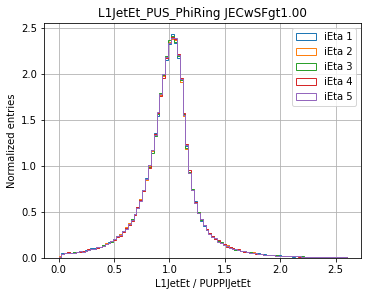

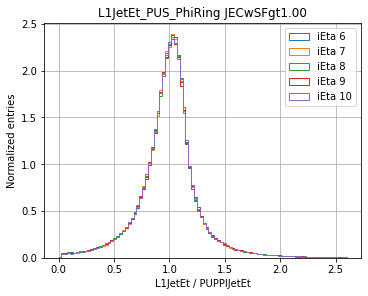

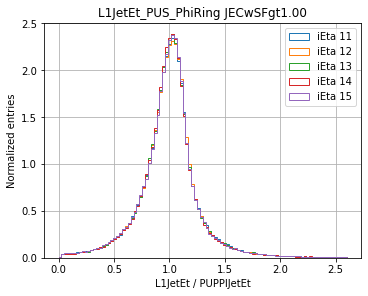

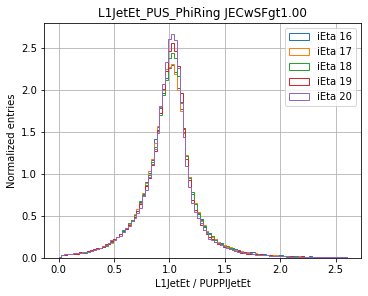

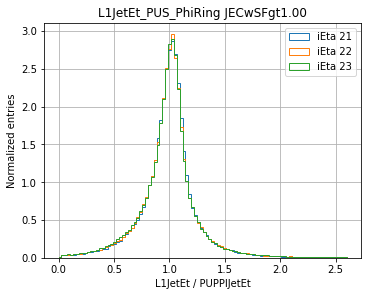

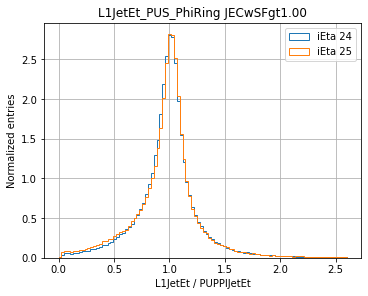

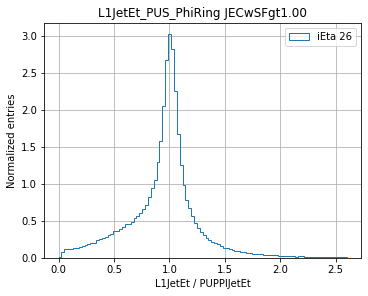

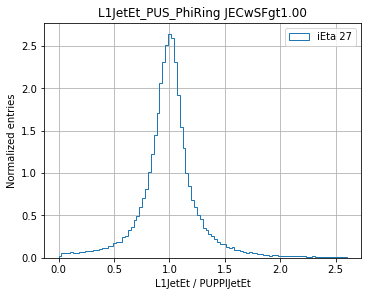

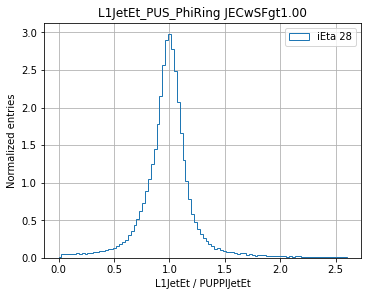

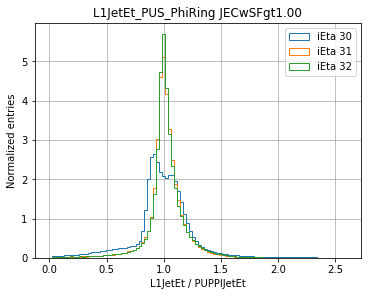

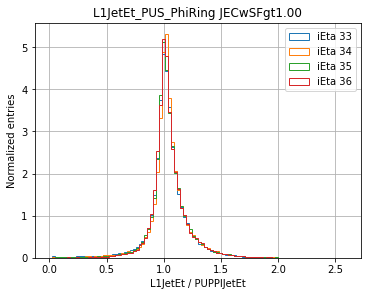

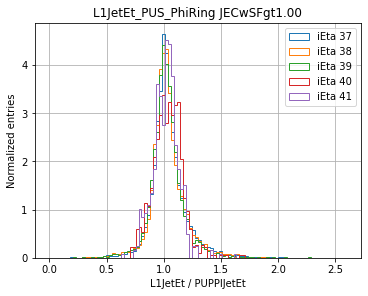

In [15]:
# Resolution plots: After JEC with  calibrateJet_wManipulate
sOutDir_toUse = '%s/AfterJECwSFgt%.2f/L1JetResponse_perEtaCat' % (sOutDir, JEC_SF_LowerBound)
os.makedirs(sOutDir_toUse, exist_ok=True )

for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
    #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    
    for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
        iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
        data_copy2_calibJetwManipulate_iEtaBin = data_copy2_calibJetwManipulate[data_copy2_calibJetwManipulate[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_copy2_calibJetwManipulate_iEtaBin[sL1JetEt_calib]/data_copy2_calibJetwManipulate_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s JECwSFgt%.2f' % (sL1JetEt, JEC_SF_LowerBound))
    axs.grid()
    axs.legend()
        
    fig.savefig('%s/AfterJECwSFgt%.2f_%s_ieta_%d_to_%d.pdf' % (sOutDir_toUse, JEC_SF_LowerBound, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))

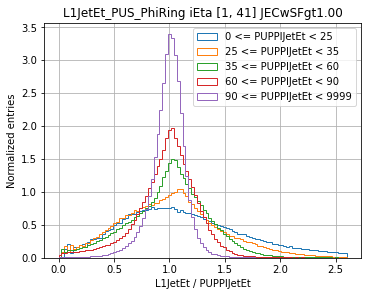

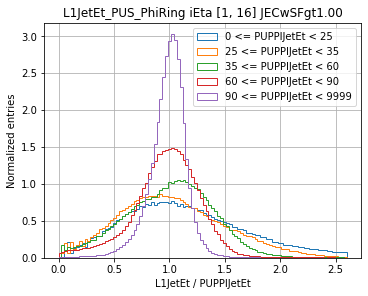

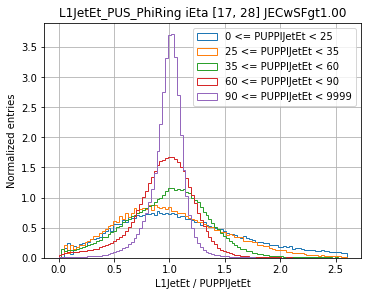

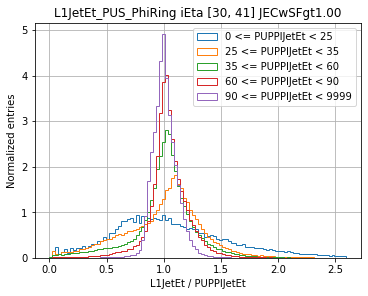

In [ ]:
# Resolution plots: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJECwSFgt%.2f/L1JetResponse_perEtaCat_perPtCat' % (sOutDir, JEC_SF_LowerBound)
# sOutDir_toUse = 'new'

os.makedirs(sOutDir_toUse, exist_ok=True )

IETA_CAT2 = OD()
IETA_CAT2['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT2['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT2['HE1']  = [17, 28]  ## Trigger towers 17 - 28
IETA_CAT2['HF']   = [30, 41]  ## Trigger towers 30 - 41

# for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():      #original
#     #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
#     fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
#     iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
#     iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])
for iEtaCatname, iEtaCatRange in IETA_CAT2.items():                     #modified to match ../makeLUTs/check_L1TJECLUT_performance.ipynb
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
    iEtaBin_first = iEtaCatRange[0]
    iEtaBin_last  = iEtaCatRange[1]
    
    for pt_cat, pt_range in PT_CAT.items(): 
        data_copy2_calibJetwManipulate_iEtaBin = data_copy2_calibJetwManipulate[ (
            (data_copy2_calibJetwManipulate[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy2_calibJetwManipulate[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
            (data_copy2_calibJetwManipulate[sRefJetEt] >= pt_range[0]) & 
            (data_copy2_calibJetwManipulate[sRefJetEt] <  pt_range[2]) )]
        axs.hist(
            (data_copy2_calibJetwManipulate_iEtaBin[sL1JetEt_calib]/data_copy2_calibJetwManipulate_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='%d <= PUPPIJetEt < %d' % (pt_range[0], pt_range[2]),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / PUPPIJetEt')
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s iEta [%d, %d] JECwSFgt%.2f' % (sL1JetEt, iEtaBin_first, iEtaBin_last, JEC_SF_LowerBound))
    axs.grid()
    axs.legend()

        # fig.savefig('%s/%siEta%d_%d_JECwSFgt%.2f.pdf' % (sOutDir_toUse, sL1JetEt, iEtaBin_first, iEtaBin_last, JEC_SF_LowerBound))
    fig.savefig('%s/AfterJECwSFgt%.2f_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir_toUse, JEC_SF_LowerBound, sL1JetEt, iEtaBin_first, iEtaBin_last))

In [17]:
def calibrateJet_wManipulate_UpperAndLowerBound(Et_0, iEta):
    Et = round(Et_0)
    if Et < calibSF_L1JetPtRange[0]: Et = round(calibSF_L1JetPtRange[0])
    if Et > calibSF_L1JetPtRange[1]: Et = round(calibSF_L1JetPtRange[1])
    #print(f"iEta {iEta}, Et {Et}")
    #sf = SFs_dict[(iEta, Et)] if Et >= 1 else SF_forZeroPt
    sf = data_calibSFs[iEta][Et] if Et >= 1 else SF_forZeroPt
    if sf < JEC_SF_LowerBound: sf = JEC_SF_LowerBound
    if sf > JEC_SF_UpperBound: sf = JEC_SF_UpperBound
    return Et_0 * sf

In [18]:
data_copy3_calibJetwManipulate_UpperAndLowerBound     = data_all[[sL1JetTowerIEtaAbs, sL1JetEt, sRefJetEt]].copy()
data_copy3_calibJetwManipulate_UpperAndLowerBound[sL1JetEt_calib] = data_copy3_calibJetwManipulate_UpperAndLowerBound.apply(lambda row: calibrateJet_wManipulate_UpperAndLowerBound(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)

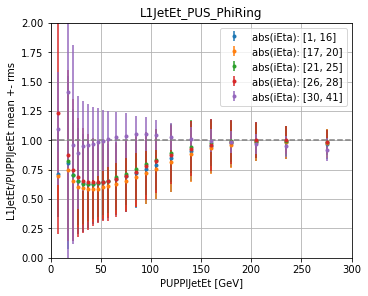

In [19]:
# L1T respones vs Pt: After JEC with  calibrateJet_wManipulate 
sOutDir_toUse = '%s/AfterJECwSFgt%.2f_SFlt%.2f/L1JetResponse_vs_Pt' % (sOutDir, JEC_SF_LowerBound, JEC_SF_UpperBound)
os.makedirs(sOutDir_toUse, exist_ok=True )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
for iEtaBinName, iEtaRange in IETA_CAT.items():
    #if iEtaBinName != 'HBEF': continue
    if iEtaBinName == 'HBEF': continue
    iEtaBin_first = iEtaRange[0]
    iEtaBin_last  = iEtaRange[1]
    
    L1JetPtResponse_vs_pt_dict = []
    L1JetPtResponseRMS_vs_pt_dict = []
    for iPtBin in range(0, len(pTBinEdges_forResolutionPlot)-1):
        pT_low  = pTBinEdges_forResolutionPlot[iPtBin]
        pT_high = pTBinEdges_forResolutionPlot[iPtBin+1]
        #print(f"{iPtBin = }, {pT_low = }, {pT_high = }")

        data_copy3_calibJetwManipulate_UpperAndLowerBound_iEtaBin = data_copy3_calibJetwManipulate_UpperAndLowerBound[ (
            (data_copy3_calibJetwManipulate_UpperAndLowerBound[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
            (data_copy3_calibJetwManipulate_UpperAndLowerBound[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
            (data_copy3_calibJetwManipulate_UpperAndLowerBound[sRefJetEt]  >= pT_low) & 
            (data_copy3_calibJetwManipulate_UpperAndLowerBound[sRefJetEt]  <  pT_high)
            ) ]
        res_ = data_copy3_calibJetwManipulate_UpperAndLowerBound_iEtaBin[sL1JetEt_calib] / data_copy3_calibJetwManipulate_UpperAndLowerBound_iEtaBin[sRefJetEt]
        L1JetPtResponse_vs_pt_dict.append( np.mean(res_) )
        L1JetPtResponseRMS_vs_pt_dict.append( np.std(res_) )
    
    axs.errorbar(
        pTBinCenters_forResolutionPlot,
        L1JetPtResponse_vs_pt_dict,
        yerr = L1JetPtResponseRMS_vs_pt_dict,
        label='abs(iEta): [%d, %d]'%(iEtaBin_first, iEtaBin_last),
        marker = '.',
        ls='none'
    )
    

axs.set_xlabel('PUPPIJetEt [GeV]')
axs.set_ylabel('L1JetEt/PUPPIJetEt mean +- rms' )
axs.set_title('%s' % (sL1JetEt))
axs.set_xlim(pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1])
axs.set_ylim(0, 2)
axs.hlines(1, pTBinEdges_forResolutionPlot[0], pTBinEdges_forResolutionPlot[-1], color='grey', ls='--')
axs.grid()
axs.legend()
    
fig.savefig('%s/L1JetResponse_vs_Pt_%s.pdf' % (sOutDir_toUse, sL1JetEt))
